## Lets Code Least Squares From Scratch

Today we will go over a really basic toy problem to demonstrate how we can solve the simple task of linear regression or line fitting with least squares and linear algebra. Understanding the math here will get us to understanding the framework used in other complex problems like inverse kinematics or the perspective-n-point problem.

### Line Fitting

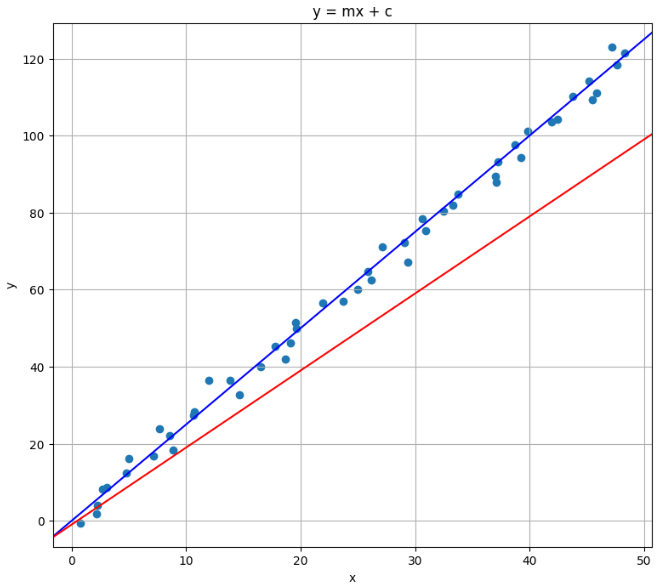

Consider the line fitting problem of $y = mx + c$. The goal is that given a set of noisy points $\{x_{0},y_{0},x_{1},y_{1},x_{2},y_{2}..\}$, i want to find the ideal $m$ and $c$ parameters. To solve for that we can say that the loss we want to minimize is: $l=\sum_{i}\left(m.x_{i}+c-y_{i}\right)^{2}$. We can actually rewrite this model in matrix form as follows:

$\quad\quad l=\sum_{i}\left(T.a-y_{i}\right)^{2}$ such that

$\quad\quad T=\left[\begin{array}{cc}
x_{i} & 1\end{array}\right]$ and $a=\left[\begin{array}{c}
m\\
c
\end{array}\right]$

This can also be rewritten exactly in the matrix form:

$\quad\quad l=\left(T.a-y\right)^{T}*\left(T.a-y\right)$

And its derivative wrt $a$ can be written in matrix form as such:

$\quad\quad \frac{dl}{da}=2.T^{T}\left(Ta-y\right)=\left(2.T^{T}.T.a-2.T^{T}.y\right)$

Lets verify the math for this with a symbolic library, and actually visualize what the loss and gradient look like as $m$ and $c$ change:

In [23]:
# Import sympy and numpy
import sympy as sp
from sympy import init_printing
sp.init_printing(use_unicode=True)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math

m, c, x = sp.symbols('m c x')
y = sp.MatrixSymbol('y', 1, 1)
a = sp.MatrixSymbol('a', 2, 1)
T = sp.MatrixSymbol('T', 1, 2)
loss = (T @ a - y).T @ (T @ a - y)
grad = loss.diff(a)
loss, grad

Now lets look at implementing this in code to verify that the math is correct. Our goal is to drop the points and the line model, and also draw the loss landscope or the manifold, along with the gradients:

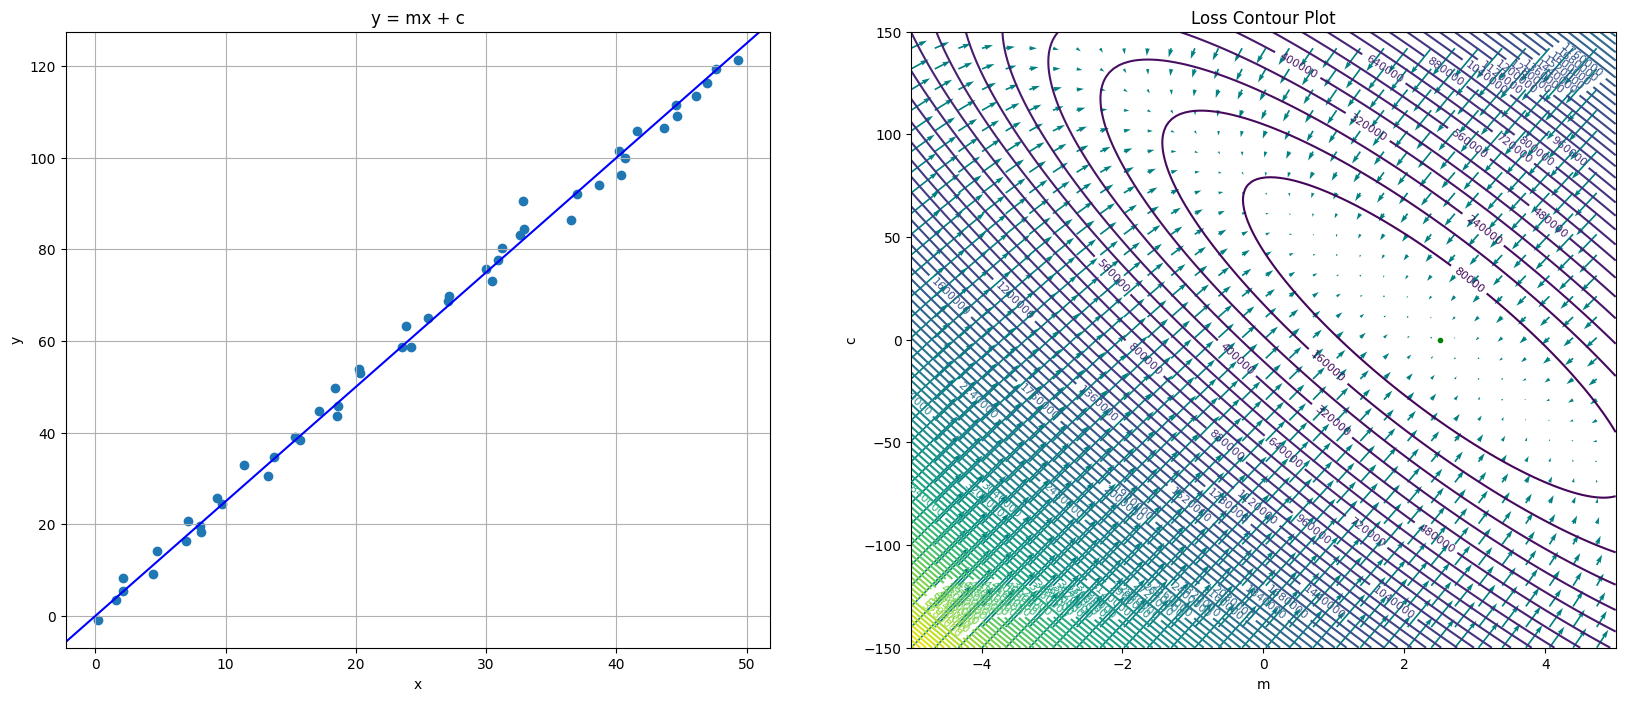

In [110]:
# We create the toy problem as described above
def line_model(points, m, c):
    # Setup T matrix of [[x0, 1], [x1, 1]..]
    T = points.copy()
    T[:, 1] = 1

    # Setup a matrix
    a = np.array([m, c])

    # Setup y matrix
    y = points[:,1].copy()

    return T, a, y

def loss_model(T, a, y):
    return (T @ a - y).T @ (T @ a - y)

def grad_model(T, a, y):
    return 2 * T.T @ (T @ a - y)

# Create sample data [50 x 2]
correct_a = [2.5, 0]
points = []
for x in range(0, 50): points.append([x*1., correct_a[0]*x + correct_a[1]])
points = np.array(points) + np.random.normal(0,1.0,(50,2))

# Generate sample data for the loss landscape
# Note that we scale the c value relative to the m value 30 times
c_scaling = 30
m_samples = np.linspace(-5, 5, 150)
c_samples = m_samples * c_scaling
M, C = np.meshgrid(m_samples, c_samples)
Z = M.copy()
Z[:,:] = None
UM = Z.copy()
UC = Z.copy()
for u in range(0, m_samples.shape[0]):
    for v in range(0, c_samples.shape[0]):
        m_val = M[u,v]
        c_val = C[u,v]
        T, a, y = line_model(points, m_val, c_val)
        loss = loss_model(T, a, y)
        grad = grad_model(T, a, y)
        Z[u,v] = loss
        if u % 5 == 0 and v% 5 == 0:
            UM[u,v] = -grad[0]*1e-5
            UC[u,v] = -grad[1]*1e-5*c_scaling

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

def draw_points_graph(ax, points):
    ax.scatter(points[:,0], points[:,1])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('y = mx + c')
    ax.grid(True)

def draw_line_graph(ax, a, color='blue'):
    xmin, xmax = ax.get_xbound()
    ymin = (xmin * a[0]) + a[1]
    ymax = (xmax * a[0]) + a[1]
    l = matplotlib.lines.Line2D([xmin, xmax], [ymin, ymax], color=color)
    ax.add_line(l)

def draw_contour(ax, a, M, C, Z, UM, UC):
    contour = ax.contour(M, C, Z, levels=100, cmap='viridis')
    quiv = ax.quiver(M, C, UM, UC, color='Teal', scale=0.5, units='xy')
    ax.plot(a[0], a[1], marker="o", markersize=3, markeredgecolor="green", markerfacecolor="green")
    plt.clabel(contour, inline=True, fontsize=8)
    plt.title('Loss Contour Plot')
    plt.xlabel('m')
    plt.ylabel('c')
        
# Draw y=mx+c graph
draw_points_graph(ax1, points)
draw_line_graph(ax1, correct_a)

# Draw contour plot
draw_contour(ax2, correct_a, M, C, Z, UM, UC)

From the graph above, you can visually see how we can start from any point on the $m, c$ area, and follow the gradient vector $\frac{dl}{da}$ we computed to reach the optimum value. You can observe here that this manifold / loss landscape has no local minima, making this problem quite easy.

Hence we have compute an $a$ value to minimize the loss, we can start with an initial value for $a$ and add the gradient iteratively with some learning rate:

$\quad\quad a = \frac{dl}{da}*lr+a$

Loss:  352.87764418539973
Final Solution:  [2.47512628 0.16209976]
Total Iterations:  9949


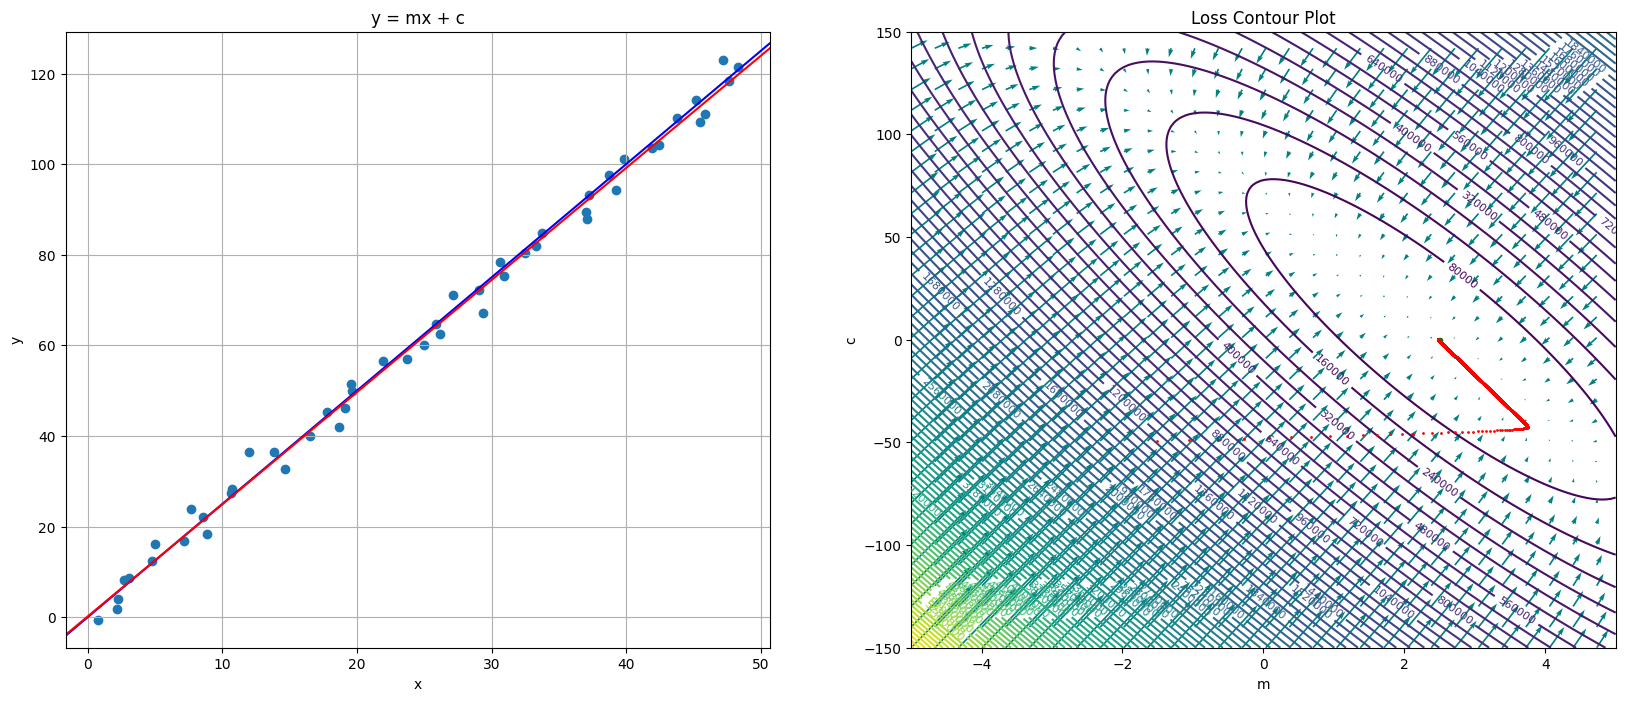

In [99]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

# Draw contour plot
draw_contour(ax2, correct_a, M, C, Z, UM, UC)

# Starting with an initial m and c value of -2, and -50, we follow the gradient down to the solution
init_a = np.array([-2, -50])
loss = 1000
prev_loss = 0
lr = 1e-6
total_iterations = 0
for i in range(0, 100000):
    T, a, y = line_model(points, init_a[0], init_a[1])
    loss = loss_model(T, a, y)
    grad = grad_model(T, a, y)

    # I have to scale the gradient of c, just as i did in the contour plot above
    grad[1] *= c_scaling
    init_a = init_a - grad * lr

    # Draw the trajectory of the m and c values
    ax2.plot(init_a[0], init_a[1], marker="o", markersize=1, markeredgecolor="red", markerfacecolor="green")

    # Termination
    if abs(prev_loss - loss) < 1e-5:
        break
    prev_loss = loss
    total_iterations = i

# Print the final value
print("Loss: ", loss)
print("Final Solution: ", init_a)
print("Total Iterations: ", total_iterations)

# Draw y=mx+c graph
draw_points_graph(ax1, points)
draw_line_graph(ax1, correct_a)
draw_line_graph(ax1, init_a, 'red')

From the above problem you can see that we spent over a thousand iterations, following the gradient to try to get to a solution, and had to do a number of scaling tricks to get it within the ballpark. This still could not yield the exact solution given the noise in the data. 

As a recap, we had updated our starting $a$ vector by modifying it

$\quad\quad \frac{dl}{da}=2.T^{T}\left(Ta-y\right)=\left(2.T^{T}.T.a-2.T^{T}.y\right)$ such that $a = \frac{dl}{da}*lr+a$

with some learning rate. However, we can also directly compute the optimal values for $a^*$ by setting $\frac{dl}{da}$ to 0:

$\quad\quad 0=\left(2.T^{T}.T.a-2.T^{T}.y\right)$

and solving for $a$ where:

$\quad\quad \left(2.T^{T}.T.a\right)=\left(2.T^{T}.y\right)$

$\quad\quad a^{*}=\left[\left(T^{T}.T\right)^{-1}.T^{T}.y\right]$

Lets verify the math for that

In [76]:
a1, T1, TT1, y1 = sp.symbols("a T T^T y", commutative=False)
eq = 2*TT1*(T1*a1 - y1)
eq.expand()
solution = sp.solve(eq.expand(), a1)
solution

And write the code for it

Loss:  352.8711154915474
Final Solution:  [2.47445139 0.18442024]
Total Iterations:  0


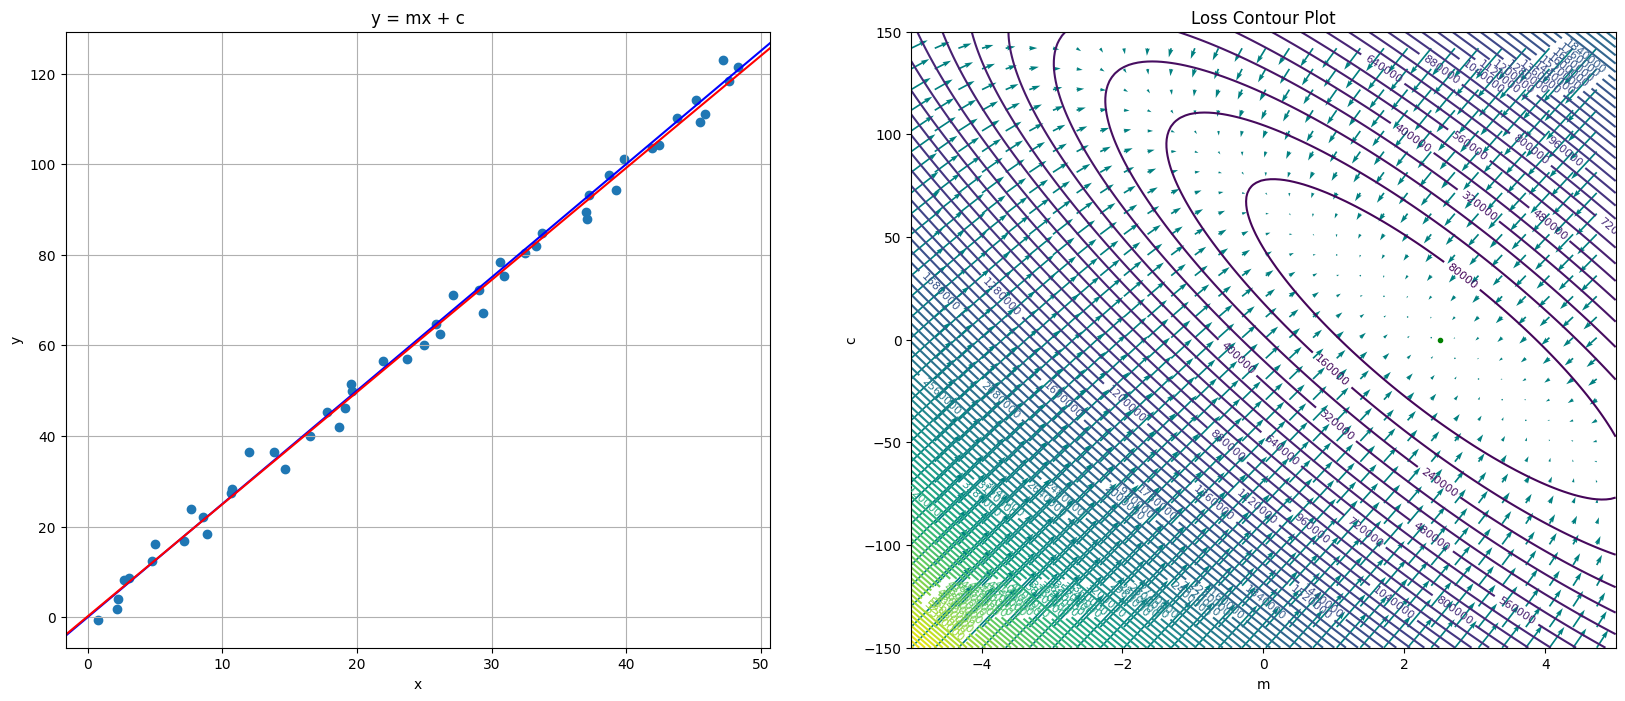

In [102]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

def optimal_step(T, a, y):
    return np.linalg.inv(T.T @ T) @ T.T @ y

def optimal_grad(T, a, y):
    return np.linalg.inv(T.T @ T) @ T.T @ (T @ a - y)

# Draw contour plot
draw_contour(ax2, correct_a, M, C, Z, UM, UC)

# Starting with an initial m and c value of -2, and -50, we can directly solve for the problem
init_a = np.array([-2, -50])
init_a = optimal_step(T, init_a, y)
loss = loss_model(T, init_a, y)

# Print the final value
print("Loss: ", loss)
print("Final Solution: ", init_a)
print("Total Iterations: ", 0)

# Draw y=mx+c graph
draw_points_graph(ax1, points)
draw_line_graph(ax1, correct_a)
draw_line_graph(ax1, init_a, 'red')

As you can see, we are able to get the optimal solution in a single step. This is because the problem was fully convex (only 1 minima), and its noise was distributed as a gaussian distribution. Typically however, we have a slight modification to the optimal step where the gradient is applied to the loss as such:

$\quad\quad \nabla=\left[\left(T^{T}.T\right)^{-1}.T^{T}.\left(Ta-y\right)\right]$

This is your Gauss-Newton algorithm (https://en.wikipedia.org/wiki/Gauss%E2%80%93Newton_algorithm)

Loss:  352.87115190464306
Final Solution:  [2.47443157 0.18419793]
Total Iterations:  115


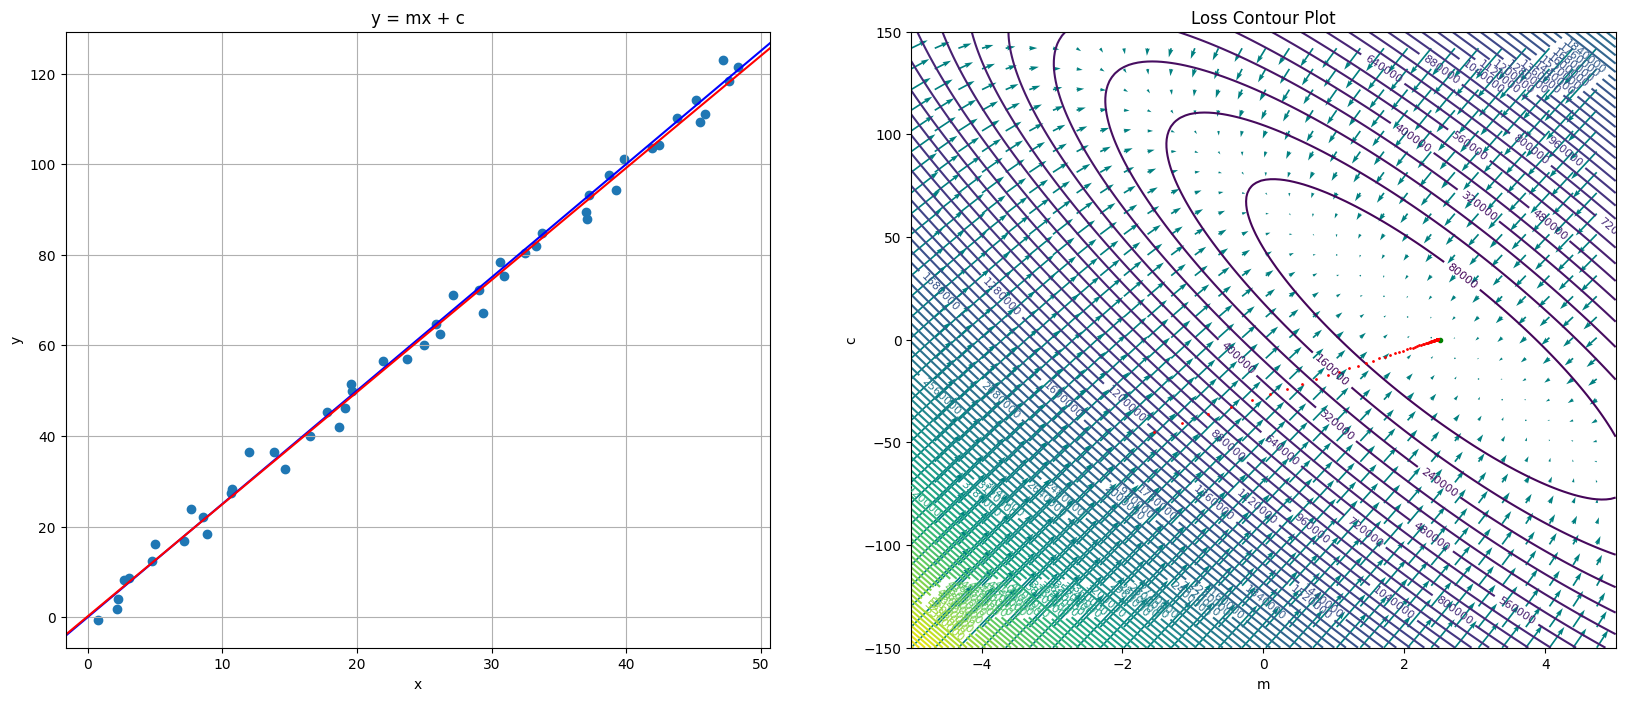

In [103]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

def optimal_grad(T, a, y):
    return np.linalg.inv(T.T @ T) @ T.T @ (T @ a - y)

# Draw contour plot
draw_contour(ax2, correct_a, M, C, Z, UM, UC)

# Starting with an initial m and c value of -2, and -50, we follow the gradient down to the solution
init_a = np.array([-2, -50])
loss = 1000
prev_loss = 0
lr = 1e-1
total_iterations = 0
for i in range(0, 5000):
    T, a, y = line_model(points, init_a[0], init_a[1])
    loss = loss_model(T, a, y)
    grad = optimal_grad(T, a, y)

    # I have to scale the gradient of c, just as i did in the contour plot above
    init_a = init_a - grad * lr

    # Draw the trajectory of the m and c values
    ax2.plot(init_a[0], init_a[1], marker="o", markersize=1, markeredgecolor="red", markerfacecolor="green")

    # Termination
    if abs(prev_loss - loss) < 1e-5:
        break
    prev_loss = loss
    total_iterations = i

# Print the final value
print("Loss: ", loss)
print("Final Solution: ", init_a)
print("Total Iterations: ", total_iterations)

# Draw y=mx+c graph
draw_points_graph(ax1, points)
draw_line_graph(ax1, correct_a)
draw_line_graph(ax1, init_a, 'red')

Now, we have some fundamentals on how an optimization problem in the least squares sense can be setup. As you can see, you typically have your state variable that you want to optimize as a vector $a$, your actual problem represented in $T$ that maps the input to output, and your target space $y$ that you want your output to tend to. These problems tend to also require that you provide a gradient or jacobian $J$ that basically tells how $Ta$ varies as $a$ varies. 

There are many more techniques and tricks in solving such problems beyond Gauss-Newton, such as Levenberg–Marquardt (https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) that automatically scales between the optimal step and the gradient step, line search (https://en.wikipedia.org/wiki/Line_search) which involves scaling the gradient at varying steps to select the one with the lowest loss, least squares with lagrangians to enforce constrains on $a$ (https://math.stackexchange.com/questions/3524690/minimizing-linear-least-squares-using-lagrangian-l-mathbfx-lambda-f-ma), Quadratic Programming (https://en.wikipedia.org/wiki/Quadratic_programming) which can be used to specify inequality constraints on $a$ by doing your search on the bounds on the manifold etc. and many many more. 